In [54]:
import pandas as pd
import string 
import demoji

C:\Users\Loli\AppData\Local\Temp\ipykernel_12516\1706834518.py:10: FutureWarning: The demoji.download_codes attribute is deprecated and will be removed from demoji in a future version. It is an unused attribute as emoji codes are now distributed directly with the demoji package.
  demoji.download_codes()


In [55]:
posts_df = pd.read_csv('cleaned_posts.csv')
posts_df.head()

,postID,originalContent,date,link,sentiment,totalLikes,totalReplies,replyToPostID,taggedSymbols,username,userid,totalImages,totalSymbols
0,29104030,Vkl luôn,2024-11-06T21:39:23.267+07:00,NaN,0,1,0,NaN,"[{""symb"": ""^DJI"", ""price"": 43496.43}]",Hoàng,5ededf24-12f7-41d9-b390-08ff631fc275,0,1
1,29104026,Đ.ịt cụ thằng Khải Trần hô VNI sập về 900 lần ...,2024-11-06T21:39:05.22+07:00,NaN,0,0,0,NaN,[],Datbg10,73778567-ec61-43eb-b3a0-b4a651b8bd3f,0,0
2,29104024,Tăng 1 phát bằng vn làm hai mấy năm :)),2024-11-06T21:39:04.077+07:00,NaN,0,12,2,NaN,"[{""symb"": ""^DJI"", ""price"": 43506.86}]",Trung Tuyến,5d597f38-3b24-4f40-952c-2b3f9be8e7d5,0,1
3,29104021,Má đáng full tiền...đau,2024-11-06T21:38:52.277+07:00,NaN,0,0,1,NaN,"[{""symb"": ""VNINDEX"", ""price"": 1261.28}]",Duc Nguyen,225659c6-cf18-4e93-aa39-a294bae5b784,1,1
4,29104019,Gap khủng long,2024-11-06T21:38:49.99+07:00,NaN,0,2,0,NaN,"[{""symb"": ""^DJI"", ""price"": 43499.54}]",BINH NHI,da8ebfa2-9cd5-4dbf-84cd-9567f694f681,0,1


In [56]:
stop_words = pd.read_csv('vietnamese-stopwords.csv')
stop_words = stop_words['word'].tolist()
stop_words = set(stop_words)

def preprocess_text_optimized(text):
    # Make all text lowercase
    text = text.lower()

    # Remove all symbols
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Replace all emojis with their descriptions
    text = demoji.replace_with_desc(text, sep = ' ')

    # Remove numbers and other special characters
    text = ''.join([i for i in text if not i.isdigit()])
    
    # Remove stop words
    return ' '.join(word for word in text.split() if word not in stop_words)

In [57]:
# only keep the originalContent sentiment link columns
posts_after_cleaned = posts_df[['originalContent', 'sentiment', 'link']]

# not interested in neutral sentiment
posts_after_cleaned = posts_after_cleaned[posts_after_cleaned['sentiment'] != 0]

# not interested in posts with link
posts_after_cleaned = posts_after_cleaned[posts_after_cleaned['link'].isnull()]

# further remove contents contains link (http, https, www, .com)
posts_after_cleaned = posts_after_cleaned[~posts_after_cleaned['originalContent'].str.contains('http|https|www|.com')]

posts_after_cleaned.drop(columns=['link'], inplace=True)

# process the text
posts_after_cleaned['originalContent'] = posts_after_cleaned['originalContent'].apply(preprocess_text_optimized)

# remove rows with content length <= 5
posts_after_cleaned = posts_after_cleaned[posts_after_cleaned['originalContent'].apply(lambda x: len(x) > 5)]
posts_after_cleaned.dropna(inplace=True)

# reindex 
posts_after_cleaned.reset_index(drop=True, inplace=True)

In [58]:
cursed_words = (pd.read_csv('Vietnamese_cursed_words.txt'))['word'].tolist()     # Danh sách từ tục tiếng Việt
cursed_words = set(cursed_words)

def contains_cursed_words(text):
    words = text.lower().split()                                                 # Chuyển thành chữ thường
    number_of_cursed_words = sum(1 for word in words if word in cursed_words)    # Đếm số từ tục
    return number_of_cursed_words

# Thêm cột 'noCursedWord' vào DataFrame
posts_after_cleaned[['noCursedWord']] = posts_after_cleaned['originalContent'].apply(contains_cursed_words).apply(pd.Series)

In [60]:
# count values
posts_after_cleaned['sentiment'].value_counts()

sentiment
 1    21159
-1    11771
Name: count, dtype: int64

Creating word clouds...


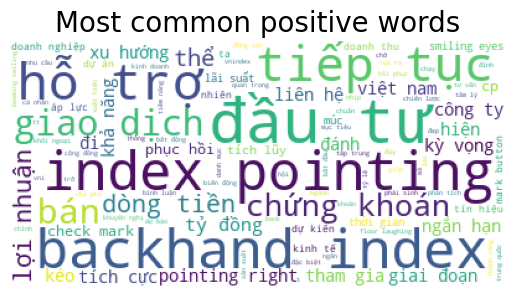

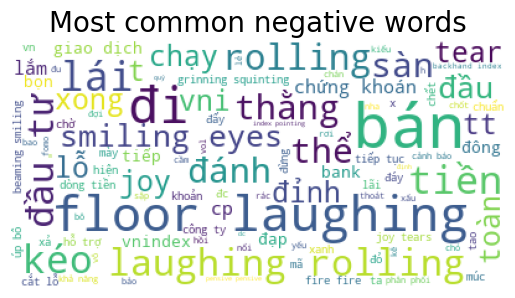

In [61]:
from wordcloud import WordCloud
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt

def generate_wordcloud(words,sentiment):
    plt.figure()
    wc = WordCloud(background_color="white", max_words=100, max_font_size=50)
    wc.generate(words)
    plt.title("Most common {} words".format(sentiment), fontsize=20)
    plt.imshow(wc.recolor(random_state=42), alpha=0.98)
    plt.axis('off')

print("Creating word clouds...")
positive_words=" ".join(posts_after_cleaned[posts_after_cleaned['sentiment'] == 1]['originalContent'].values)
negative_words=" ".join(posts_after_cleaned[posts_after_cleaned['sentiment'] == -1]['originalContent'].values)

generate_wordcloud(positive_words,"positive")
generate_wordcloud(negative_words,"negative")

In [62]:
from sklearn.model_selection import train_test_split

# Undersampling the majority class, then split the data
posts_after_cleaned_orig = posts_after_cleaned.copy()
positive_samples = posts_after_cleaned_orig[posts_after_cleaned_orig['sentiment'] == 1]
negative_samples = posts_after_cleaned_orig[posts_after_cleaned_orig['sentiment'] == -1]

# Undersample the positive class
positive_samples = positive_samples.sample(n=len(negative_samples), random_state=69)

# Concatenate the two classes
posts_after_cleaned_RandomUnderSampling = pd.concat([positive_samples,negative_samples])

X_train_pre = posts_after_cleaned_RandomUnderSampling.drop("sentiment",axis=1)
y_train_pre = posts_after_cleaned_RandomUnderSampling["sentiment"]

X_train_pre, X_test_pre, y_train_pre, y_test_pre = train_test_split(X_train_pre,y_train_pre,test_size = 0.15, random_state=69, stratify=y_train_pre)  # 85% for training
X_val_pre, X_test_pre, y_val_pre, y_test_pre = train_test_split(X_test_pre,y_test_pre,test_size = 0.5, random_state=69, stratify=y_test_pre)        # 7.5% for validation, 7.5% for testing

print(posts_after_cleaned_RandomUnderSampling['sentiment'].value_counts())

print("Data distribution:\n- Train: {} \n- Validation: {} \n- Test: {}".format(len(y_train_pre),len(y_val_pre),len(y_test_pre)))
print("Training data distribution:\n",y_train_pre.value_counts())
print("Validation data distribution:\n",y_val_pre.value_counts())
print("Testing data distribution:\n",y_test_pre.value_counts())

sentiment
 1    11771
-1    11771
Name: count, dtype: int64
Data distribution:
- Train: 20010 
- Validation: 1766 
- Test: 1766
Training data distribution:
 sentiment
 1    10005
-1    10005
Name: count, dtype: int64
Validation data distribution:
 sentiment
 1    883
-1    883
Name: count, dtype: int64
Testing data distribution:
 sentiment
-1    883
 1    883
Name: count, dtype: int64


In [63]:
from sklearn.feature_extraction.text import TfidfVectorizer

def vectorize(data,tfidf_vect_fit: TfidfVectorizer):
    X_tfidf = tfidf_vect_fit.transform(data)
    words = tfidf_vect_fit.get_feature_names_out()
    X_tfidf_df = pd.DataFrame(X_tfidf.toarray())
    X_tfidf_df.columns = words
    return(X_tfidf_df)

# Create tfidf base fit
tfidf = TfidfVectorizer(analyzer = 'word', min_df=40, max_df=0.2)
tfidf_vect_fitted=tfidf.fit(posts_after_cleaned_orig['originalContent'])

# Vectorize the training data
X_train=vectorize(X_train_pre['originalContent'],tfidf_vect_fitted)
X_train['noCursedWord'] = X_train_pre['noCursedWord']

y_train=y_train_pre.copy()

X_train.shape

(20010, 1626)

In [147]:
def print_results(results):
    print('BEST PARAMS: {}\n'.format(results.best_params_))

    means = results.cv_results_['mean_test_score']
    stds = results.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, results.cv_results_['params']):
        print('{} (+/-{}) for {}'.format(round(mean, 3), round(std * 2, 3), params))

In [148]:
# RF chưa tinh chỉnh
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate

scoring = ["accuracy"]                              # Tiêu chí đánh giá
rf = RandomForestClassifier(n_jobs=-1)              # Khởi tạo model Random Forest
cv_res = cross_validate(rf, X_train, y_train, scoring=scoring)  # Cross validation
print(f"General accuracy: {cv_res["test_accuracy"].mean()}")

General accuracy: 0.7187346326836581
Balanced accuracy: 0.7187346326836581


In [13]:
# Tinh chỉnh tham số sử dụng GridSearchCV
from sklearn.model_selection import GridSearchCV
rf = RandomForestClassifier()

parameters = {
    'n_estimators': [50,100,200],          # Số cây
    'max_features': ['sqrt', 'log2'],      # Số features tối đa mỗi cây
    'max_depth': [30,None]                 # Độ sâu tối đa mỗi cây
}

cv = GridSearchCV(rf, parameters, n_jobs=-1)  # Thử với model Random Forest
cv.fit(X_train,y_train.values.ravel())        # Fit với dữ liệu train
print_results(cv)                             # Hàm phụ trợ in kết quả

BEST PARAMS: {'max_depth': None, 'max_features': 'log2', 'n_estimators': 200}

0.706 (+/-0.011) for {'max_depth': 30, 'max_features': 'sqrt', 'n_estimators': 50}
0.703 (+/-0.015) for {'max_depth': 30, 'max_features': 'sqrt', 'n_estimators': 100}
0.702 (+/-0.017) for {'max_depth': 30, 'max_features': 'sqrt', 'n_estimators': 200}
0.678 (+/-0.01) for {'max_depth': 30, 'max_features': 'log2', 'n_estimators': 50}
0.684 (+/-0.01) for {'max_depth': 30, 'max_features': 'log2', 'n_estimators': 100}
0.686 (+/-0.012) for {'max_depth': 30, 'max_features': 'log2', 'n_estimators': 200}
0.732 (+/-0.013) for {'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 50}
0.732 (+/-0.013) for {'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 100}
0.736 (+/-0.013) for {'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 200}
0.736 (+/-0.01) for {'max_depth': None, 'max_features': 'log2', 'n_estimators': 50}
0.738 (+/-0.014) for {'max_depth': None, 'max_features': 'log2', 'n_estimators':

In [64]:
# Vectorize the validation data
X_val=vectorize(X_val_pre['originalContent'], tfidf_vect_fitted)
X_val['noCursedWord'] = X_val_pre['noCursedWord']
y_val=y_val_pre.copy()

def print_results_each(mdl: RandomForestClassifier, time, test_set = y_val):
    bal_acc = balanced_accuracy_score(test_set,y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(test_set, y_pred, average='weighted')
    print('MAX FEATURES: {} / NUMBER OF EST: {} -- Time: {} / Acc: {} / Precision: {} / Recall: {} / F1: {}'.format(mdl.max_features,
                                                                         mdl.n_estimators,
                                                                         round(time,3),
                                                                         round(bal_acc,3),
                                                                         round(precision,3),
                                                                         round(recall,3),
                                                                         round(f1,3)))

from sklearn.metrics import balanced_accuracy_score, precision_recall_fscore_support
import time

# 3 model tốt nhất
rf1 = RandomForestClassifier(n_estimators=200, max_features = 'log2', max_depth=None, n_jobs=-1)
rf2 = RandomForestClassifier(n_estimators=100, max_features = 'log2', max_depth=None, n_jobs=-1)
rf3 = RandomForestClassifier(n_estimators=200, max_features = 'sqrt', max_depth=None, n_jobs=-1)

for model in [rf1,rf2,rf3]:                         # Thử từng model
    start = time.time()                             # Bắt đầu đếm thời gian
    model.fit(X_train, y_train.values.ravel())      # Fit với tập train
    y_pred = model.predict(X_val)                   # Dự đoán tập validation
    end = time.time()                               # Kết thúc đếm thời gian
    print_results_each(model, time = end-start)     # Hàm phụ trợ in kết quả

ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- noCursedWord


In [44]:
X_test = vectorize(X_test_pre['originalContent'],tfidf_vect_fitted)
# X_test['noCursedWord'] = X_test_pre['noCursedWord']
y_test = y_test_pre.copy()

from sklearn.metrics import classification_report
mdl = rf1                       # Chọn model tốt nhất
y_pred = mdl.predict(X_test)

print_results_each(mdl, time=0, test_set=y_test)
print(classification_report(y_test, y_pred))

MAX FEATURES: log2 / NUMBER OF EST: 200 -- Time: 0 / Acc: 0.742 / Precision: 0.742 / Recall: 0.742 / F1: 0.742
              precision    recall  f1-score   support

          -1       0.74      0.74      0.74       883
           1       0.74      0.74      0.74       883

    accuracy                           0.74      1766
   macro avg       0.74      0.74      0.74      1766
weighted avg       0.74      0.74      0.74      1766



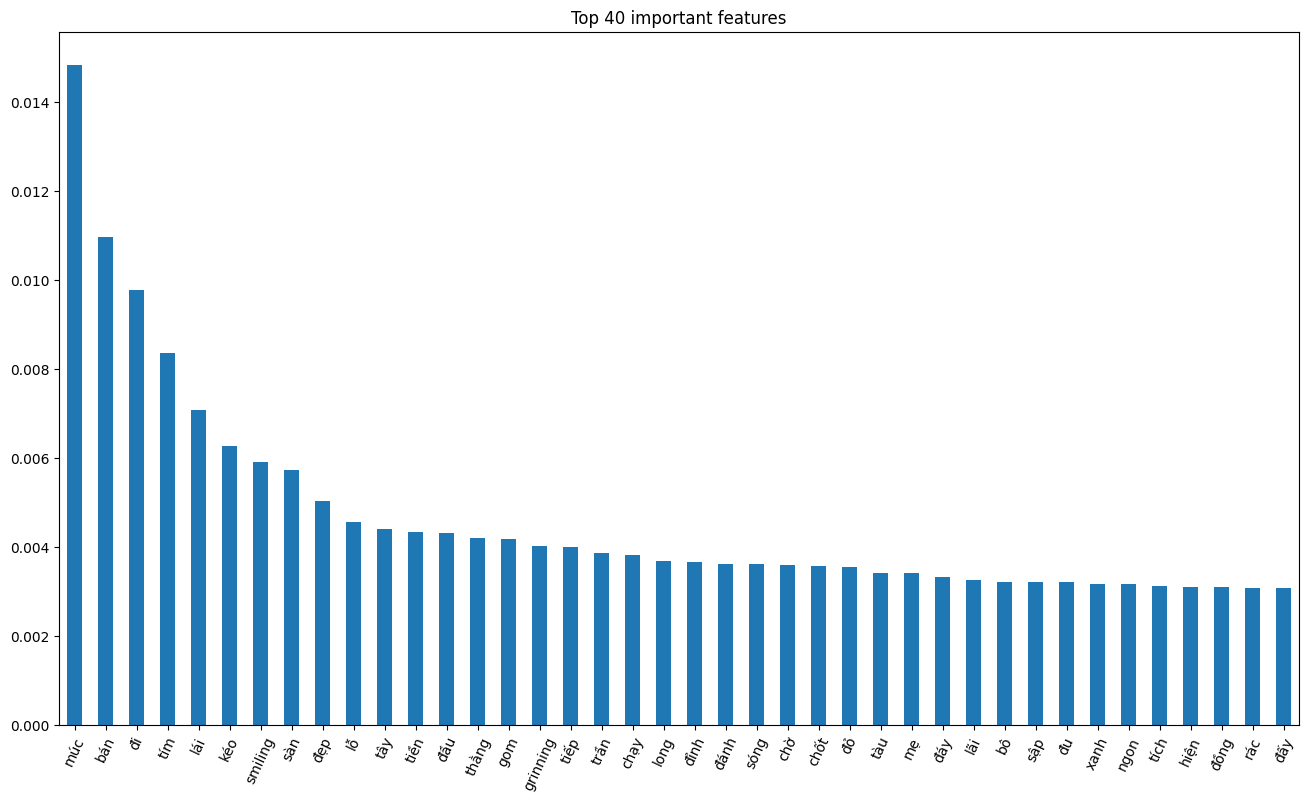

In [41]:
feat_importances = pd.Series(rf1.feature_importances_, index=X_train.columns)
feat_importances.nlargest(40).plot(kind='bar',figsize=(16,9))
plt.xticks(rotation=65)
plt.title("Top 40 important features")
plt.show()

#### Thử thư viện `imbalanced-learn`

In [65]:
NUMBER_TEST_EACH = 900

posts_after_cleaned_imblearn = posts_after_cleaned.copy()

# Make sure the test set is balanced by manually undersampling the majority class
positive_samples = posts_after_cleaned_imblearn[posts_after_cleaned_imblearn["sentiment"] == 1]
negative_samples = posts_after_cleaned_imblearn[posts_after_cleaned_imblearn["sentiment"] == -1]

# Select the same number of positive samples as negative samples
posts_test_set_positive = positive_samples.sample(n=NUMBER_TEST_EACH, random_state=42)
posts_test_set_negative = negative_samples.sample(n=NUMBER_TEST_EACH, random_state=42)

# Concatenate the two classes
posts_test_set = pd.concat([posts_test_set_positive,posts_test_set_negative])
posts_train_set = posts_after_cleaned_imblearn.drop(posts_test_set.index)

X_train_imb = posts_train_set.drop("sentiment",axis=1)
y_train_imb = posts_train_set["sentiment"]

X_test_imb = posts_test_set.drop("sentiment",axis=1)
y_test_imb = posts_test_set["sentiment"]

# Vectorize the training data
X_train_imb = vectorize(X_train_imb['originalContent'],tfidf_vect_fitted)
X_train_imb['noCursedWord'] = posts_train_set['noCursedWord']

X_test_imb = vectorize(X_test_imb['originalContent'],tfidf_vect_fitted)
X_test_imb['noCursedWord'] = posts_test_set['noCursedWord']

# Fill nan with 0
X_train_imb.fillna(0,inplace=True)
X_test_imb.fillna(0,inplace=True)

print("Data distribution:\n- Train: {} \n- Test: {}".format(len(y_train_imb),len(y_test_imb)))
print("Training data distribution:\n",y_train_imb.value_counts())
print("Testing data distribution:\n",y_test_imb.value_counts())

Data distribution:
- Train: 31130 
- Test: 1800
Training data distribution:
 sentiment
 1    20259
-1    10871
Name: count, dtype: int64
Testing data distribution:
 sentiment
 1    900
-1    900
Name: count, dtype: int64


In [70]:
from sklearn.metrics import balanced_accuracy_score, precision_recall_fscore_support
from sklearn.metrics import classification_report

def print_results_each2(test_set = y_val):
    bal_acc = balanced_accuracy_score(test_set,y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(test_set, y_pred, average='weighted')
    print('Acc: {} / Precision: {} / Recall: {} / F1: {}'.format(
                                                                         round(bal_acc,3),
                                                                         round(precision,3),
                                                                         round(recall,3),
                                                                         round(f1,3)))
    print(classification_report(test_set, y_pred))

from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate

rf_clf = make_pipeline(
    BalancedRandomForestClassifier(
        sampling_strategy="all", replacement=True, bootstrap=False,     # Xét toàn bộ mẫu
        n_estimators=200, max_features="log2", max_depth=None,          # Tham số tối ưu từ trước
        random_state=42, n_jobs=-1,
    ),
)

cv_res = cross_validate(rf_clf, X_train_imb, y_train_imb, scoring=scoring)   # Cross validation
print(f"General accuracy: {cv_res["test_accuracy"].mean()}")                 # Trung bình accuracy

rf_clf.fit(X_train_imb, y_train_imb)                        # Fit với tập train
y_pred = rf_clf.predict(X_test_imb)                         # Dự đoán tập test
print_results_each2(test_set=y_test_imb)                    # Hàm phụ trợ in kết quả

General accuracy: 0.7398329585608737
Acc: 0.762 / Precision: 0.762 / Recall: 0.762 / F1: 0.762
              precision    recall  f1-score   support

          -1       0.76      0.76      0.76       900
           1       0.76      0.77      0.76       900

    accuracy                           0.76      1800
   macro avg       0.76      0.76      0.76      1800
weighted avg       0.76      0.76      0.76      1800



In [71]:
from imblearn.under_sampling import (
    AllKNN,
    RepeatedEditedNearestNeighbours,
)

samplers = [
    AllKNN(allow_minority=True),
    RepeatedEditedNearestNeighbours(),
]

for sampler in samplers:
    print(f"Running {sampler}")
    X_train_imb_resampled, y_train_imb_resampled = sampler.fit_resample(X_train_imb, y_train_imb)
    print("Resampled data distribution:\n",y_train_imb_resampled.value_counts())

    cv_res = cross_validate(rf_clf, X_train_imb_resampled, y_train_imb_resampled, scoring=scoring)
    print(f"General accuracy: {cv_res["test_accuracy"].mean()}")
    print(f"Balanced accuracy: {cv_res["test_balanced_accuracy"].mean()}")
    print()

    # Fit the model
    rf_clf.fit(X_train_imb_resampled, y_train_imb_resampled)

    # Evaluate the model
    y_pred = rf_clf.predict(X_test_imb)
    print_results_each2(test_set=y_test_imb)


Running AllKNN(allow_minority=True)
Resampled data distribution:
 sentiment
-1    8775
 1    7242
Name: count, dtype: int64
General accuracy: 0.8939885282329338
Balanced accuracy: 0.8921288883179347

Acc: 0.723 / Precision: 0.738 / Recall: 0.723 / F1: 0.719
              precision    recall  f1-score   support

          -1       0.68      0.85      0.75       900
           1       0.80      0.60      0.68       900

    accuracy                           0.72      1800
   macro avg       0.74      0.72      0.72      1800
weighted avg       0.74      0.72      0.72      1800

Running RepeatedEditedNearestNeighbours()
Resampled data distribution:
 sentiment
-1    10871
 1     7408
Name: count, dtype: int64
General accuracy: 0.8554627365169262
Balanced accuracy: 0.8506615638341852

Acc: 0.719 / Precision: 0.748 / Recall: 0.719 / F1: 0.711
              precision    recall  f1-score   support

          -1       0.66      0.89      0.76       900
           1       0.83      0.55      0